In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from scipy.stats import spearmanr
from scipy.stats import wilcoxon

In [6]:
out_path = '200515_inner_bootstrap'
save_images = False

In [7]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [8]:
pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})
pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [9]:
p = inout.get_internal_path(
    'datasets/tstoeger/200129_pool_inner_bootstraps/age_groups.csv.gz')

In [10]:
df = pd.read_csv(p)

In [11]:
df.head()

,gene_ncbi,gene_ensembl,o_over_y,pvalue,padj,tissue,pfu,age,animals
0,13424.0,ENSMUSG00000018707,0.659082,0.000071,0.366242,Heart,0,4,14-29-30
1,17263.0,ENSMUSG00000021268,3.051627,0.000078,0.366242,Heart,0,4,14-29-30
2,20191.0,ENSMUSG00000021313,0.565963,0.000036,0.366242,Heart,0,4,14-29-30
3,75956.0,ENSMUSG00000039218,0.799816,0.000046,0.366242,Heart,0,4,14-29-30
4,170720.0,ENSMUSG00000013483,6.358493,0.000106,0.395879,Heart,0,4,14-29-30


In [12]:
tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

In [13]:
df = df[
    (df['tissue'].isin(tissues_to_consider)) &
    (df['padj'].notnull())

].copy()



In [14]:
renamer = {
        'Adrenal': 'Adrenal Gland', 
        'BAT': 'Brown adipose tissue', 
        'Blood': 'Blood', 
        'Brain': 'Frontal cortex', 
        'Esophagus': 'Esophagus', 
        'GutEP': 'Gut epithelium', 
        'Heart': 'Heart',
        'Kidney': 'Kidney', 
        'LI': 'Large intestine', 
        'Liver': 'Liver', 
        'Lung': 'Lung', 
        'MuscSat': 'Muscle', 
        'SI': 'Small intestine', 
        'Skin': 'Skin',
        'Stomach': 'Stomach', 
        'WAT': 'White adipose tissue', 
        'Cerebellum': 'Cerebellum'}


df['tissue'] = df['tissue'].replace(renamer)

In [15]:
df = df.dropna(subset=['gene_ncbi'])

In [16]:
master = pd.merge(df, pr)

In [17]:
grouped = master.groupby(['tissue', 'age', 'animals'])

In [18]:
agg = []
for name, group in grouped:
    tissue, age, animals = name
    rho, pval = spearmanr(group['length'], group['o_over_y'])
    
    res = dict()
    res['tissue'] = tissue
    res['age'] = age
    res['rho'] = rho
    res['pval'] = pval
    res['animals'] = animals
    
    agg.append(res)

In [19]:
mega = pd.DataFrame(agg)

In [20]:
toy = mega[(mega['tissue']=='Large intestine') & (mega['age']==24)]

In [21]:
toy

,tissue,age,rho,pval,animals
852,Large intestine,24,0.372127,0.000000e+00,1-16-17
853,Large intestine,24,0.297421,5.181434e-233,1-16-18
854,Large intestine,24,0.231287,3.767477e-139,1-17-18
855,Large intestine,24,0.347920,0.000000e+00,1-2-16
856,Large intestine,24,0.275934,1.527119e-199,1-2-17
857,Large intestine,24,0.157032,3.068535e-64,1-2-18
858,Large intestine,24,0.362193,0.000000e+00,1-2-3
859,Large intestine,24,0.795081,4.349340e-223,1-3-16
860,Large intestine,24,0.390453,0.000000e+00,1-3-17
861,Large intestine,24,0.328180,3.201721e-286,1-3-18


In [22]:
mega.loc[:, 'abs_rho'] = mega['rho'].abs()

In [23]:
import seaborn as sns

In [24]:
p = export.get_material_path(
    '190406_transcript_length_tilting/stats_on_imbalance_190407_0052.xlsx')

In [25]:
df_orig = pd.read_excel(p)

In [26]:
df_orig = df_orig[
    (df_orig['younger']==4) & (df_orig['older']==24)
]

In [27]:
df_orig = df_orig[df_orig['tissue'].isin(tissues_to_consider)].copy()
df_orig['tissue'] = df_orig['tissue'].replace(renamer)


In [28]:
df_new = mega.copy()

In [29]:
colors = ["#000000", '#1B75BB', '#00A69C', '#F6921E', '#EC1C24']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

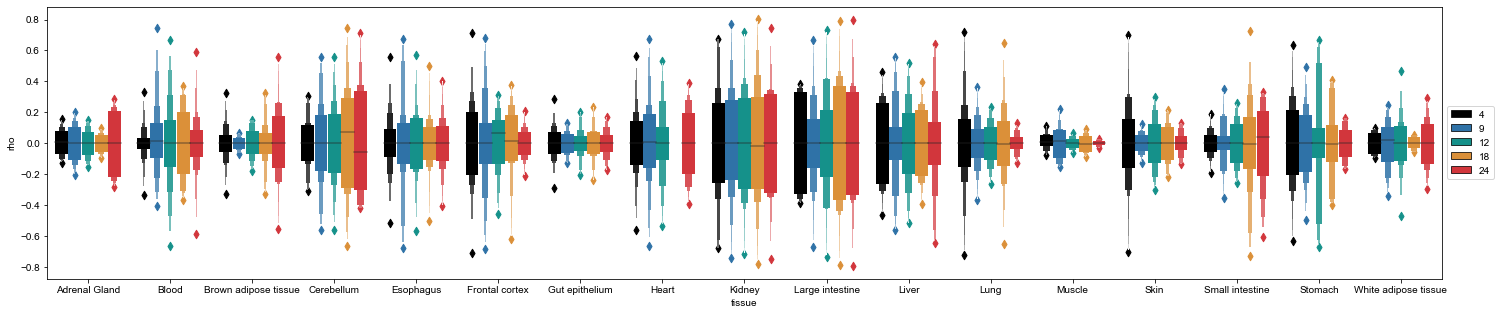

In [30]:
plt.figure(figsize=(25, 5))


mini = sns.boxenplot(
    x='tissue',
    y='rho',
    hue='age',
    data=df_new,
    order=sorted(df_orig.sort_values('corr')['tissue']),
    palette=customPalette
)

if save_images:
    export.export_image('{}/correlations_boxen.pdf'.format(out_path))



plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



In [31]:
(df_new.groupby(['tissue', 'age']).size() == 20).mean()

0.8452380952380952

In [32]:
df_new.groupby(['tissue', 'age']).size().value_counts()

20    71
10    11
6      2
dtype: int64

In [33]:
np.percentile(df_new.groupby(['tissue', 'age']).size(), 25)

20.0

In [34]:
np.percentile(df_new.groupby(['tissue', 'age']).size(), 75)

20.0

In [35]:
np.percentile(df_new.groupby(['tissue', 'age']).size(), 50)

20.0

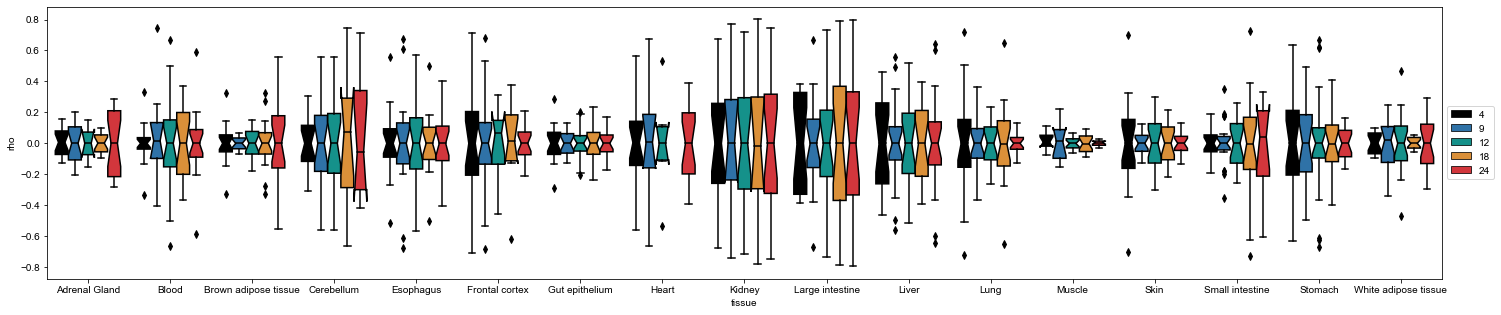

In [36]:
plt.figure(figsize=(25, 5))


mini = sns.boxplot(
    x='tissue',
    y='rho',
    hue='age',
    data=df_new,
    order=sorted(df_orig.sort_values('corr')['tissue']),
    notch=True
)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


if save_images:
    export.export_image('{}/correlations.pdf'.format(out_path))



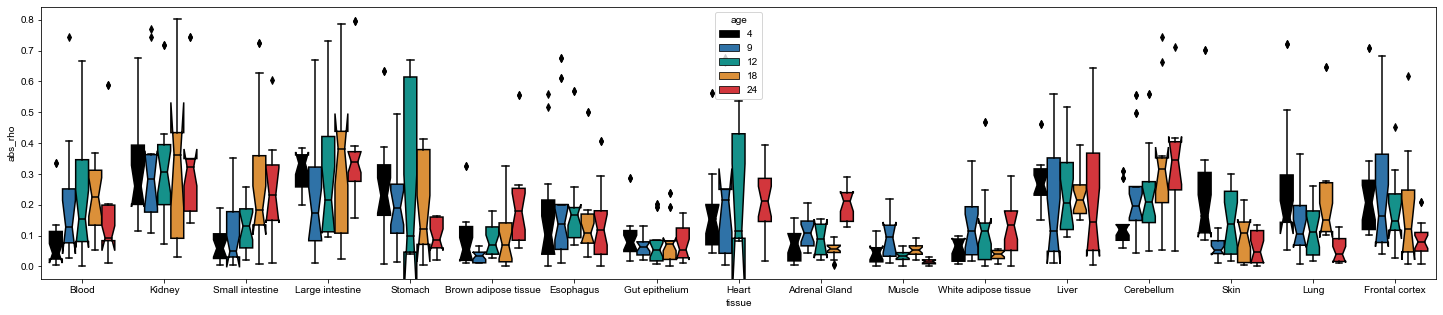

In [37]:
plt.figure(figsize=(25, 5))


mini = sns.boxplot(
    x='tissue',
    y='abs_rho',
    hue='age',
    data=df_new,
    order=df_orig.sort_values('corr')['tissue'],
    notch=True
)

if save_images:
    export.export_image('{}/all_absolute_correlations.pdf'.format(out_path))



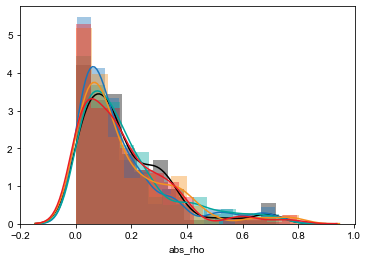

In [38]:
sns.distplot(df_new[df_new['age']==4]['abs_rho'])
sns.distplot(df_new[df_new['age']==9]['abs_rho'])
sns.distplot(df_new[df_new['age']==12]['abs_rho'])
sns.distplot(df_new[df_new['age']==18]['abs_rho'])
sns.distplot(df_new[df_new['age']==24]['abs_rho'])

if save_images:
    export.export_image('{}/by_agedistributions_absolute_correlations.pdf'.format(out_path))

In [39]:
np.quantile(df_new['abs_rho'], 0.5)

0.12010238243323512

In [40]:
np.quantile(df_new['abs_rho'], 0.9)

0.3709408919676365

In [41]:
d = df_new.groupby(['age', 'tissue']).agg(np.median).reset_index()

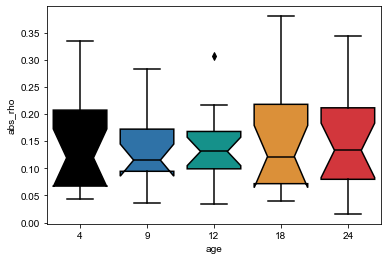

In [42]:
sns.boxplot(
    x='age',
    y='abs_rho',
    data=d,
    notch=True
)


if save_images:
    export.export_image('{}/absolute_by_tissue.pdf'.format(out_path))

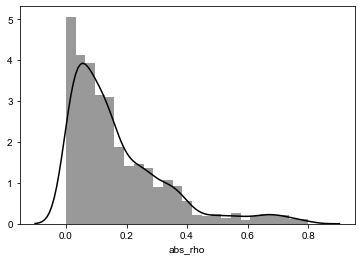

In [43]:
sns.distplot(df_new['abs_rho'])

if save_images:
    export.export_image('{}/all_distributions_absolute_correlations.pdf'.format(out_path))

In [44]:
df_new['pct'] = df_new['abs_rho'].rank(pct=True)

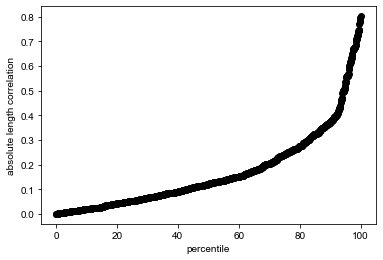

In [45]:
plt.scatter(df_new['pct']*100, df_new['abs_rho'])
plt.xlabel('percentile')
plt.ylabel('absolute length correlation')


if save_images:
    export.export_image('{}/ranks.pdf'.format(out_path))